In [1]:
import numpy as np
import imp
import pickle
from scipy.stats import norm
import lmfit

In [2]:
# Initialise wrapper
wrapper_fpath = (r"..\mobius.py")
wr = imp.load_source('mobius', wrapper_fpath)
wr.initialize('../../Applications/SimplyC/simplyc_regional.dll')

# Calibration functions
calib_fpath = (r"..\mobius_calib_uncert_lmfit.py")
cu = imp.load_source('mobius_calib_uncert_lmfit', calib_fpath)

In [3]:


calib_locations = ['Langtjern', 'Storgama', 'Birkenes']

landuse_classes = ['Forest', 'Shrubbery', 'Bog']

landuse = {
    'Langtjern' : [73, 5,  22],
    'Storgama'  : [11, 67, 22],
    'Birkenes'  : [90, 3,  7],
}

In [4]:
#NOTE: Here the input file name is only used for structuring, which is fine. No input data is read in
#template_dataset = wr.DataSet.setup_with_blank_index_sets('../../Applications/SimplyC/Storgama/inputs_Storgama.dat')
#template_dataset.set_indexes('Landscape units', landuse_classes)
#template_dataset.set_branch_indexes('Reaches', [('R0', [])])
#template_dataset.set_parameter_uint('Timesteps', [], timesteps)
#template_dataset.set_parameter_time('Start date', [], start_date)

#parfile = 'template_pars.dat'
parfile = 'optimal1.dat'
inputfile = 'template_inputs.dat'
template_dataset = wr.DataSet.setup_from_parameter_and_input_files(parfile, inputfile)

#For now, just run all in 1986-01-01 to 2012-12-31 since it is tricky to have different ranges on them.
timesteps = template_dataset.get_parameter_uint('Timesteps', [])
start_date = template_dataset.get_parameter_time('Start date', [])

param_df = cu.get_double_parameters_as_dataframe(template_dataset)
param_df

,name,unit,index,min_value,initial_value,max_value
0,Latitude,°,(),-90.000000,6.060000e+01,9.000000e+01
1,Elevation,m,(),0.000000,0.000000e+00,8.848000e+03
2,PET multiplication factor,dimensionless,(),1.000000,1.259922e+00,2.000000e+00
3,Net emissivity at 0 vapor pressure,dimensionless,(),0.000000,3.400000e-01,1.000000e+00
4,Change in emissivity caused by vapor pressure,kPa^{-1/2},(),0.000000,1.390000e-01,5.000000e-01
5,Initial snow depth as water equivalent,mm,(),0.000000,0.000000e+00,5.000000e+04
6,Degree-day factor for snowmelt,mm/°C/day,(),0.000000,2.695089e+00,5.000000e+00
7,Snow melt offset temperature,°C,(),-4.000000,0.000000e+00,4.000000e+00
8,Temperature at which precipitation falls as snow,°C,(),-4.000000,0.000000e+00,4.000000e+00
9,Snow fall multiplier,dimensionless,(),0.500000,1.000000e+00,1.500000e+00


In [5]:
vars = [
    2, 6,                #hydrology
    10, 11,              #hydrology
    17, 18, 19,          #soil tc (hydrology)
    28,                  #soil temp
    30, 31, 32,          #soil temp
    33, 34,              #global carbon
    35, 36, 37,          #lu carbon
    38, 39, 40,          #lu carbon
]

calib_df = param_df.loc[vars].reset_index(drop=True)
calib_df

,name,unit,index,min_value,initial_value,max_value
0,PET multiplication factor,dimensionless,(),1.00,1.259922e+00,2.000
1,Degree-day factor for snowmelt,mm/°C/day,(),0.00,2.695089e+00,5.000
2,Proportion of precipitation that contributes t...,dimensionless,(),0.00,4.232465e-11,1.000
3,Soil field capacity,mm,(),0.00,1.104255e+02,1000.000
4,Soil water time constant,days,"(Forest,)",0.01,1.670581e+00,40.000
5,Soil water time constant,days,"(Shrubbery,)",0.01,2.049233e+00,40.000
6,Soil water time constant,days,"(Bog,)",0.01,1.961818e+00,40.000
7,Snow depth / soil temperature factor,/cm,(),-3.00,-1.383018e+00,-0.001
8,"Soil thermal conductivity (W/m/°C, range 0.4-0...",1E-6 m2/s,"(Forest,)",0.01,1.098731e-01,0.800
9,"Soil thermal conductivity (W/m/°C, range 0.4-0...",1E-6 m2/s,"(Shrubbery,)",0.01,1.098731e-01,0.800


In [6]:
# Add 'short_name' column for calibrating parameters
calib_df['short_name'] = [
    'alphaPET', 'DDFmelt',
    'fquick', 'fc',
    'Ts_F', 'Ts_S', 'Ts_B',
    'sdst', 'Stc_F', 'Stc_S', 'Stc_B',
    'kT', 'kSO4',
    'Cdiss_F', 'Cdiss_S', 'Cdiss_B',
    'DOCb_F', 'DOCb_S', 'DOCb_B',
]

In [7]:
# Convert to LMFit parameter object
params = cu.parameter_df_to_lmfit(calib_df)


params['kT'].min = 0.0
params['kT'].max = 0.2

params['kSO4'].min = 0.0
params['kSO4'].max = 0.2

params['Stc_S'].set(expr='Stc_F')
params['Stc_B'].set(expr='Stc_F')

for lu in ['F', 'S', 'B'] :
    params['DOCb_%s' % lu].min = 1.0
    params['DOCb_%s' % lu].max = 14.0
    
    params['Cdiss_%s' % lu].max = 3.0

#TODO: see if this is ok:
params['Cdiss_S'].set(expr='Cdiss_F')
params['Cdiss_B'].set(expr='Cdiss_F')

#params['fquick'].min = 0.0
params['fquick'].max = 0.1

#params['Ts'].max = 5.0

params['alphaPET'].max = 3.0

params

name,value,initial value,min,max,vary,expression
alphaPET,1.25992202,1.2599220160493403,1.00000000,3.00000000,True,
DDFmelt,2.69508879,2.6950887902818907,0.00000000,5.00000000,True,
fquick,4.2325e-11,4.232464934084143e-11,0.00000000,0.10000000,True,
fc,110.425469,110.425468911528,0.00000000,1000.00000,True,
Ts_F,1.67058133,1.6705813271943404,0.01000000,40.0000000,True,
Ts_S,2.04923345,2.04923345267291,0.01000000,40.0000000,True,
Ts_B,1.96181781,1.9618178128517108,0.01000000,40.0000000,True,
sdst,-1.38301830,-1.3830183031469903,-3.00000000,-1.0000e-03,True,
Stc_F,0.10987313,0.10987312577730811,0.01000000,0.80000000,True,
Stc_S,0.10987313,0.10987312577730811,0.01000000,0.80000000,False,Stc_F


In [8]:
#These will be used to get physical data along with input time series:
initial_datasets = {}

for loc in calib_locations :
    parfile = '../../Applications/SimplyC/%s/params_%s_regional.dat' % (loc, loc)
    inpfile = '../../Applications/SimplyC/%s/inputs_%s.dat' % (loc, loc)
    initial_datasets[loc] = wr.DataSet.setup_from_parameter_and_input_files(parfile, inpfile)
    
    #NOTE: this is to make everything align up when copying input data below:
    initial_datasets[loc].set_parameter_uint('Timesteps', [], timesteps)
    initial_datasets[loc].set_parameter_time('Start date', [], start_date)

In [9]:
datasets = {}

for loc in calib_locations :
    dataset = template_dataset.copy()
        
    for par in ['Latitude', 'Elevation'] :
        dataset.set_parameter_double(par, [], initial_datasets[loc].get_parameter_double(par, []))
    
    for par in ['Reach length', 'Reach slope', 'Catchment area', 'Initial in-stream flow'] :
        dataset.set_parameter_double(par, ['R0'], initial_datasets[loc].get_parameter_double(par, [loc]))
    
    for idx, lu in enumerate(landuse_classes) :
        dataset.set_parameter_double('Land use proportions', ['R0', lu], landuse[loc][idx]*0.01)   #percentage to 0-1 range
        
    for inp in template_dataset.get_input_list() :
        name, _ = inp
        series = initial_datasets[loc].get_input_series(name, [], alignwithresults=True)
        dataset.set_input_series(name, [], series, alignwithresults=False)
    
    datasets[loc] = dataset

In [10]:
comparisons = [
                ('Reach flow (daily mean, cumecs)', ['R0'], 'Observed flow', []),
                ('Reach DOC concentration (volume weighted daily mean)', ['R0'], 'Observed DOC', []),
                #('DOC flux from reach, daily mean', 'DOC flux', True),
               ]

In [11]:
def normal_weight(series) :
    size = np.count_nonzero(~np.isnan(series))
    return series / np.sqrt(size)

# Custom residual function that takes into account yearly sums as well as daily values
def resid(params, datasets, comparisons, norm=False, skip_timesteps=0) :
    
    residuals = []
    
    for loc in calib_locations :
        
        dataset_copy = datasets[loc].copy()
        cu.set_parameter_values(params, dataset_copy)
        dataset_copy.run_model()

        for i, comparison in enumerate(comparisons):
            simname, simindexes, obsname, obsindexes = comparison

            sim = dataset_copy.get_result_series(simname, simindexes)[skip_timesteps:]
            obs = dataset_copy.get_input_series(obsname, obsindexes, alignwithresults=True)[skip_timesteps:]

            if np.isnan(sim).any() :
                raise ValueError('Got a NaN in the simulated data')

            resid = sim - obs

            #residuals.append(normal_weight(resid))
            residuals.append(resid)

        dataset_copy.delete()   
    
    return np.concatenate(residuals)

Location: Langtjern

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.005963
Mean absolute error: 0.012815
Root mean square error: 0.024759
Nash-Sutcliffe coefficient: 0.322578
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -3.257767
Mean absolute error: 3.381995
Root mean square error: 4.184118
Nash-Sutcliffe coefficient: -0.691915
Number of observations: 981

Location: Storgama

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.007053
Mean absolute error: 0.012821
Root mean square error: 0.027119
Nash-Sutcliffe coefficient: 0.322914
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -0.222311
Mean absolute error: 1.091343
Root mean square error: 1.355190
Nash-Sutcliffe coefficient: 0.094418

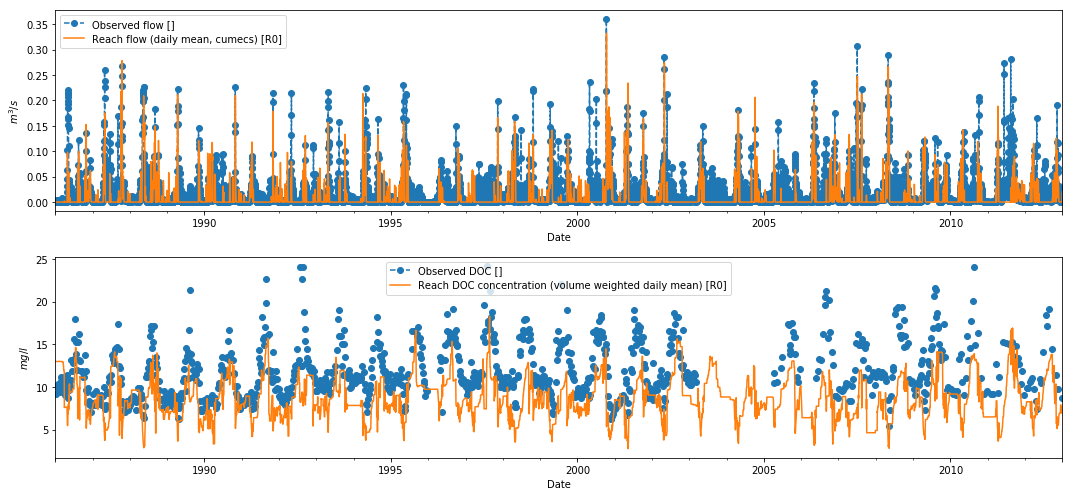

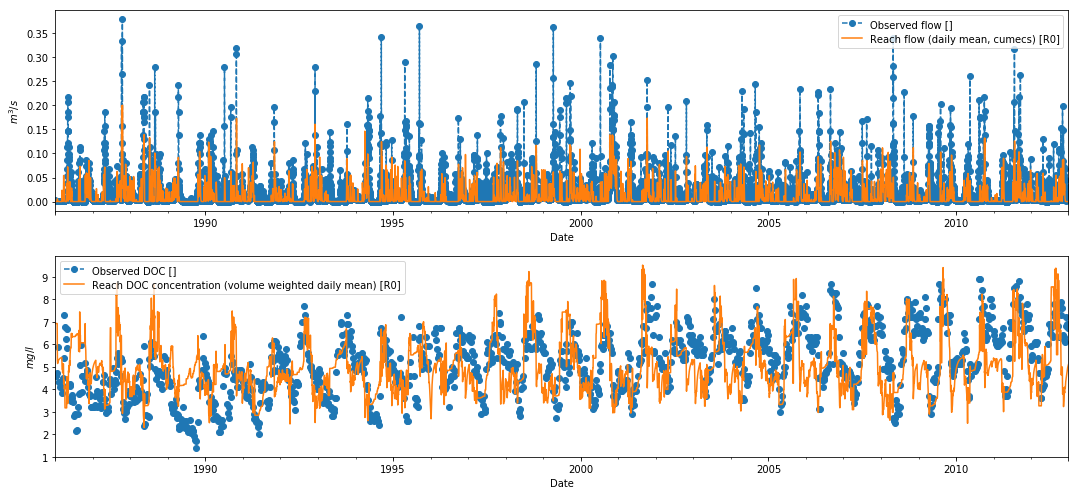

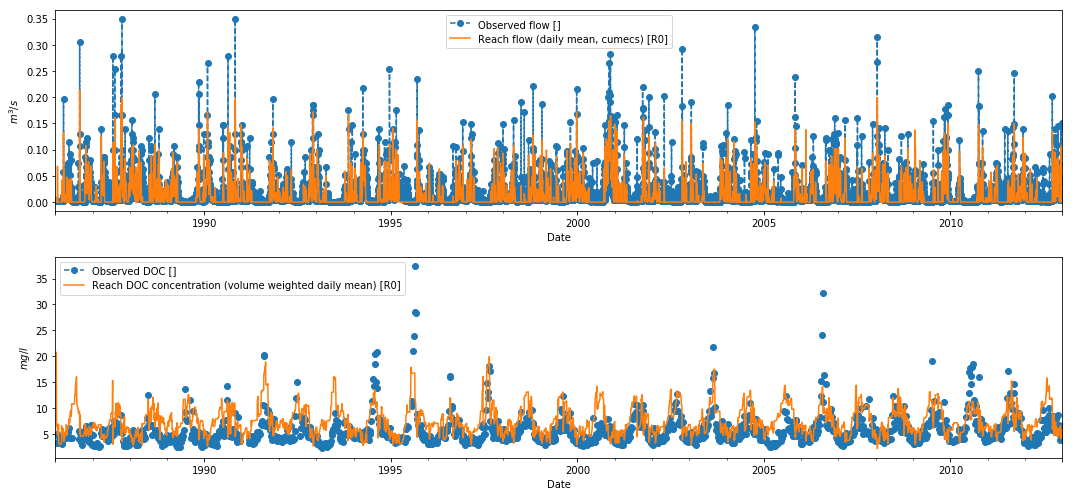

In [12]:
for loc in calib_locations :
    datasets[loc].run_model()
    print('Location: %s' % loc)
    cu.print_goodness_of_fit(datasets[loc], comparisons, skip_timesteps=365)
    cu.plot_objective(datasets[loc], comparisons)

In [13]:
def iter_cb(params, iter, resid, *args, **kws) :
    if iter % 10 == 0 :
        print('Iteration: %d, residual: %g' % (iter, np.nansum(resid*resid)) )
        #params.pretty_print(precision=3)

In [14]:
%%time

mi, res = cu.minimize_residuals(params, datasets, comparisons, residual_method=resid, method='nelder', iter_cb=iter_cb, norm=False, 
                                skip_timesteps=365)

print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Iteration: 10, residual: 34927.6
Iteration: 20, residual: 34128.5
Iteration: 30, residual: 35753.8
Iteration: 40, residual: 239610
Iteration: 50, residual: 47897.1
Iteration: 60, residual: 35945.1
Iteration: 70, residual: 34474.1
Iteration: 80, residual: 34257
Iteration: 90, residual: 34126.8
Iteration: 100, residual: 36550.4
Iteration: 110, residual: 34124.2
Iteration: 120, residual: 34104.9
Iteration: 130, residual: 34098.6
Iteration: 140, residual: 34095.9
Iteration: 150, residual: 34082.6
Iteration: 160, residual: 34078.2
Iteration: 170, residual: 34089.2
Iteration: 180, residual: 34076.8
Iteration: 190, residual: 34063.3
Iteration: 200, residual: 34084
Iteration: 210, residual: 34052
Iteration: 220, residual: 34053.3
Iteration: 230, residual: 34057.8
Iteration: 240, residual: 34048.3
Iteration: 250, residual: 34060.1
Iteration: 260, residual: 34046.8
Iteration: 270, residual: 34054
Iteration: 280, residual: 34046.5
Iteration: 290, residual: 34044.7
Iteration: 300, residual: 34045.

Iteration: 2400, residual: 33922.3
Iteration: 2410, residual: 33922.3
Iteration: 2420, residual: 33923.6
Iteration: 2430, residual: 33922.3
Iteration: 2440, residual: 33923.6
Iteration: 2450, residual: 33923.6
Iteration: 2460, residual: 33923.6
Iteration: 2470, residual: 33922.2
Iteration: 2480, residual: 33922.2
Iteration: 2490, residual: 33922.2
Iteration: 2500, residual: 33922.2
Iteration: 2510, residual: 33922.2
Iteration: 2520, residual: 33922.2
Iteration: 2530, residual: 33923
Iteration: 2540, residual: 33923
Iteration: 2550, residual: 33922.2
Iteration: 2560, residual: 33922.2
Iteration: 2570, residual: 33922.1
Iteration: 2580, residual: 33923.5
Iteration: 2590, residual: 33922.1
Iteration: 2600, residual: 33922.1
Iteration: 2610, residual: 33922.1
Iteration: 2620, residual: 33922.1
Iteration: 2630, residual: 33922.1
Iteration: 2640, residual: 33922
Iteration: 2650, residual: 33922
Iteration: 2660, residual: 33922
Iteration: 2670, residual: 33923.4
Iteration: 2680, residual: 339

Iteration: 4770, residual: 42336.2
Iteration: 4780, residual: 316453
Iteration: 4790, residual: 62871.8
Iteration: 4800, residual: 33625.2
Iteration: 4810, residual: 36548.8
Iteration: 4820, residual: 46807
Iteration: 4830, residual: 339487
Iteration: 4840, residual: 358341
Iteration: 4850, residual: 342906
Iteration: 4860, residual: 339516
Iteration: 4870, residual: 905179
Iteration: 4880, residual: 45508.9
Iteration: 4890, residual: 200450
Iteration: 4900, residual: 98940.6
Iteration: 4910, residual: 41903.6
Iteration: 4920, residual: 92333.6
Iteration: 4930, residual: 62271.1
Iteration: 4940, residual: 51508.1
Iteration: 4950, residual: 36189.1
Iteration: 4960, residual: 50727.4
Iteration: 4970, residual: 45489.1
Iteration: 4980, residual: 84893.2
Iteration: 4990, residual: 64208.1
Iteration: 5000, residual: 84397.5
Iteration: 5010, residual: 53667.3
Iteration: 5020, residual: 152167
Iteration: 5030, residual: 58240
Iteration: 5040, residual: 34641
Iteration: 5050, residual: 34893.1

Iteration: 7140, residual: 70686.9
Iteration: 7150, residual: 36102.8
Iteration: 7160, residual: 33509
Iteration: 7170, residual: 36002.2
Iteration: 7180, residual: 45909.1
Iteration: 7190, residual: 36985.6
Iteration: 7200, residual: 34586.6
Iteration: 7210, residual: 36918.8
Iteration: 7220, residual: 37425.8
Iteration: 7230, residual: 59571.7
Iteration: 7240, residual: 45981.3
Iteration: 7250, residual: 59554.7
Iteration: 7260, residual: 47102.1
Iteration: 7270, residual: 65329.9
Iteration: 7280, residual: 46710.2
Iteration: 7290, residual: 33926.5
Iteration: 7300, residual: 33933.2
Iteration: 7310, residual: 34091.6
Iteration: 7320, residual: 33945.1
Iteration: 7330, residual: 33983.8
Iteration: 7340, residual: 33918.5
Iteration: 7350, residual: 33982.9
Iteration: 7360, residual: 34083.2
Iteration: 7370, residual: 33990.8
Iteration: 7380, residual: 33922.5
Iteration: 7390, residual: 34202.3
Iteration: 7400, residual: 34489.1
Iteration: 7410, residual: 33995.2
Iteration: 7420, resid

Iteration: 9500, residual: 34453
Iteration: 9510, residual: 34582.6
Iteration: 9520, residual: 34841.4
Iteration: 9530, residual: 34581.9
Iteration: 9540, residual: 33922.1
Iteration: 9550, residual: 33922.1
Iteration: 9560, residual: 33928.2
Iteration: 9570, residual: 33922.3
Iteration: 9580, residual: 33919.8
Iteration: 9590, residual: 33917.8
Iteration: 9600, residual: 33919.9
Iteration: 9610, residual: 33921.9
Iteration: 9620, residual: 33919.9
Iteration: 9630, residual: 33917.8
Iteration: 9640, residual: 33932.4
Iteration: 9650, residual: 33937.1
Iteration: 9660, residual: 33914.8
Iteration: 9670, residual: 34080.9
Iteration: 9680, residual: 33940.8
Iteration: 9690, residual: 34242.8
Iteration: 9700, residual: 33937
Iteration: 9710, residual: 33965
Iteration: 9720, residual: 33934.7
Iteration: 9730, residual: 214563
Iteration: 9740, residual: 34273.2
Iteration: 9750, residual: 34068.4
Iteration: 9760, residual: 34030.9
Iteration: 9770, residual: 34072.4
Iteration: 9780, residual: 

C:\Users\magnu\AppData\Roaming\Python\Python37\site-packages\numdifftools\limits.py:182: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  f_del = np.vstack(list(np.ravel(r)) for r in sequence)
C:\Users\magnu\AppData\Roaming\Python\Python37\site-packages\numdifftools\limits.py:184: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  for step in steps)
C:\Program Files\Python37\lib\site-packages\lmfit\minimizer.py:780: RuntimeWarning: invalid value encountered in sqrt
  par.stderr = sqrt(self.result.covar[ivar, ivar])
C:\Program Files\Python37\lib\site-packages\lmfit\minimizer.py:787: RuntimeWarning: invalid value encountered in sqrt
  (par.stderr * sqrt(self.res

In [15]:
print('Optimisation results:\n')
lmfit.report_fit(res)
print('\n\nOptimised parameter values:\n')
res.params.pretty_print(precision=3)

Optimisation results:

[[Fit Statistics]]
    # fitting method   = Nelder-Mead
    # function evals   = 3366
    # data points      = 32104
    # variables        = 15
    chi-square         = 33921.6922
    reduced chi-square = 1.05711279
    Akaike info crit   = 1798.09777
    Bayesian info crit = 1923.74881
##  Warning: uncertainties could not be estimated:
    fquick:    at initial value
    fquick:    at boundary
[[Variables]]
    alphaPET:  1.24313532 +/-        nan (nan%) (init = 1.259922)
    DDFmelt:   2.69094712 +/-        nan (nan%) (init = 2.695089)
    fquick:    4.2842e-11 +/-        nan (nan%) (init = 4.232465e-11)
    fc:        110.101707 +/- 1.26655918 (1.15%) (init = 110.4255)
    Ts_F:      1.60162000 +/-        nan (nan%) (init = 1.670581)
    Ts_S:      2.01342199 +/-        nan (nan%) (init = 2.049233)
    Ts_B:      1.93361699 +/-        nan (nan%) (init = 1.961818)
    sdst:     -1.37922132 +/- 0.13069150 (9.48%) (init = -1.383018)
    Stc_F:     0.11545000 +/-

Location: Langtjern

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.005859
Mean absolute error: 0.012820
Root mean square error: 0.024744
Nash-Sutcliffe coefficient: 0.323415
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -3.144510
Mean absolute error: 3.290272
Root mean square error: 4.088529
Nash-Sutcliffe coefficient: -0.615492
Number of observations: 981

Location: Storgama

Goodness of fit for Reach flow (daily mean, cumecs) [R0] vs Observed flow []:
Mean error (bias): -0.006995
Mean absolute error: 0.012801
Root mean square error: 0.027051
Nash-Sutcliffe coefficient: 0.326331
Number of observations: 9496


Goodness of fit for Reach DOC concentration (volume weighted daily mean) [R0] vs Observed DOC []:
Mean error (bias): -0.363571
Mean absolute error: 1.121258
Root mean square error: 1.389232
Nash-Sutcliffe coefficient: 0.048351

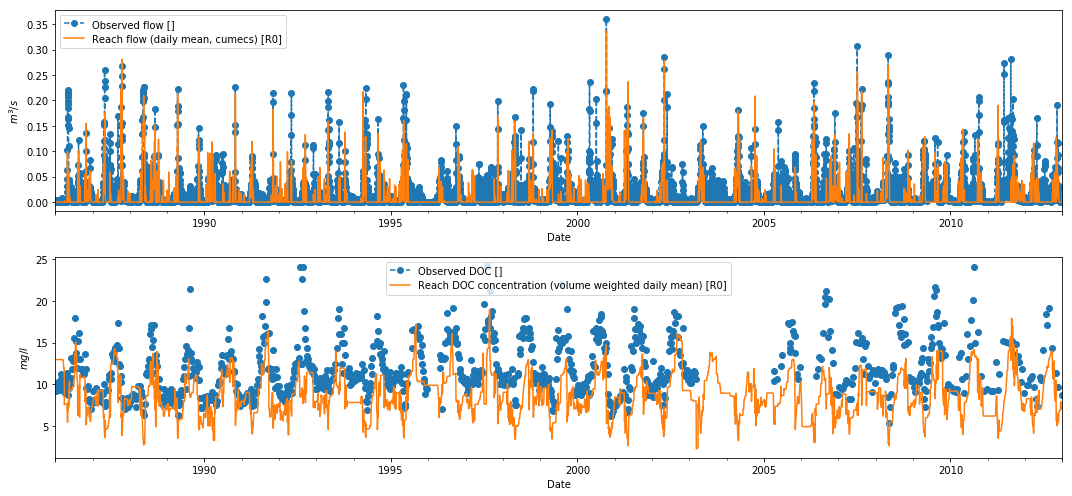

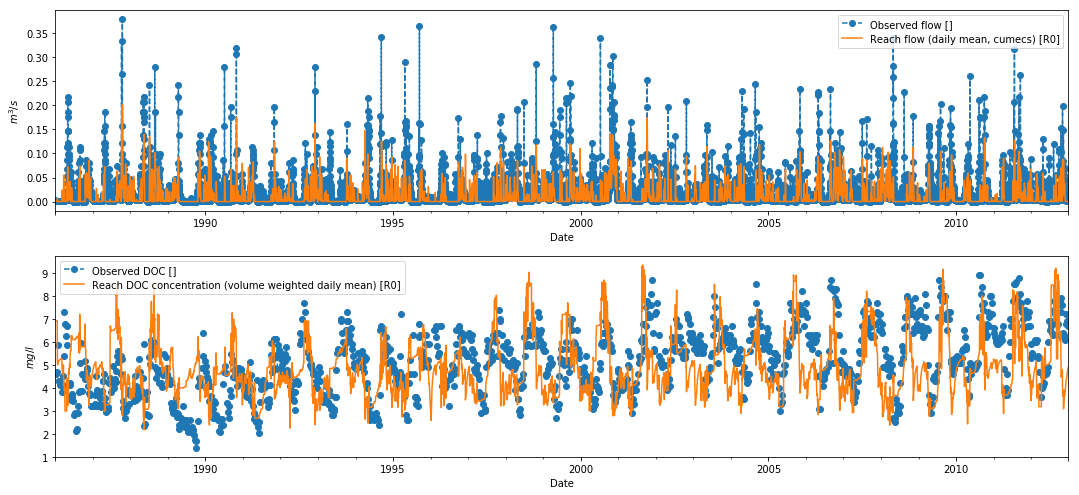

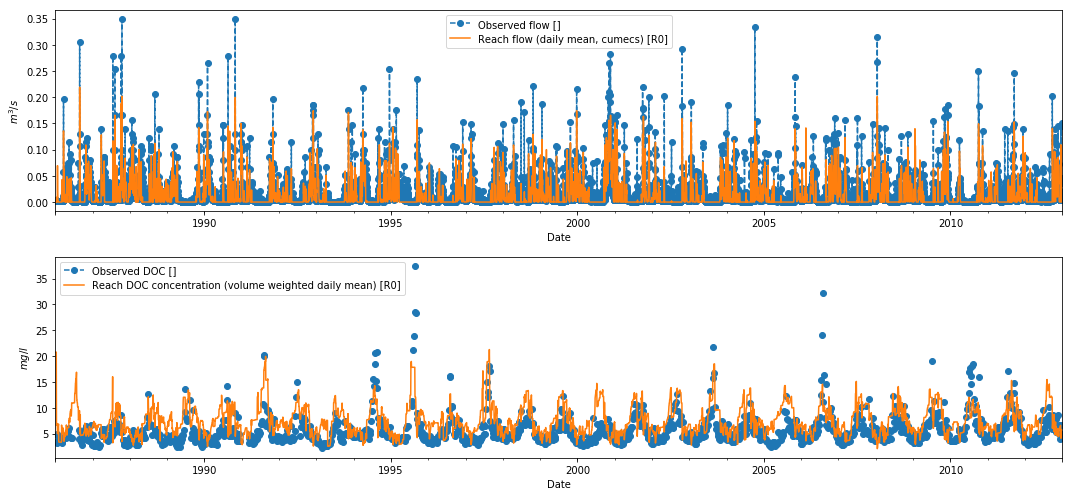

In [16]:
for loc in calib_locations :
    cu.set_parameter_values(res.params, datasets[loc])
    datasets[loc].run_model()
    print('Location: %s' % loc)
    cu.print_goodness_of_fit(datasets[loc], comparisons, skip_timesteps=365)
    cu.plot_objective(datasets[loc], comparisons)

In [17]:
datasets['Langtjern'].write_parameters_to_file('optimal2.dat')